In [1]:
import torch

CONTENT_FILE = './input/input_boy.wav'
STYLE_FILE = './input/input_girl.wav'

learning_rate = 0.001

content_weight = 1.0
style_weight = 1.0

print_period = 100
max_epochs = 2000

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

In [2]:
from utils import *
import torch

N_FFT = 512


x_content, sr = loadFile(CONTENT_FILE)
x_style, sr = loadFile(STYLE_FILE)

a_content = wav2spectrum(x_content, N_FFT)
a_style = wav2spectrum(x_style, N_FFT)

print(x_content.shape, a_content.shape)
print(x_style.shape, a_style.shape)
print(sr)


(77947,) (257, 609)
(94045,) (257, 735)
22050


# Training

In [3]:
import torch.optim as optim
from models import *


model = RandomCNN()
model.eval()



a_C = torch.tensor(a_content[None, None, :, :], requires_grad = False, device = device).float()
a_S = torch.tensor(a_style[None, None, :, :], requires_grad = False, device = device).float()


# optimizer
a_G_var = torch.randn(a_C.shape, device = device) * 0.001
a_G_var.requires_grad = True

optimizer = optim.Adam(
    params = [a_G_var],
    lr = learning_rate,
)

model.to(device)

a_C = model(a_C)
a_S = model(a_S)


losses = []
style_losses = []
content_losses = []

for epoch in range(1, max_epochs + 1):

    optimizer.zero_grad()
    a_G = model(a_G_var)
    
    content_loss = content_weight * RandomCNN.compute_content_loss(a_C, a_G)
    style_loss = style_weight * RandomCNN.compute_layer_style_loss(a_S, a_G)

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    if epoch % print_period == 0:
        print('{}/{} content_loss: {:4f}, style_loss: {:4f}, total_loss: {:4f}'.format(
            epoch,
            max_epochs,
            content_loss,
            style_loss,
            loss
        ))

    losses.append(loss.detach().cpu())
    content_losses.append(content_loss.detach().cpu())
    style_losses.append(style_loss.detach().cpu())

gen_spectrum = a_G_var.cpu().data.numpy().squeeze()


100/2000 content_loss: 0.051870, style_loss: 1746.707397, total_loss: 1746.759277
200/2000 content_loss: 0.045522, style_loss: 1466.591431, total_loss: 1466.636963
300/2000 content_loss: 0.042679, style_loss: 1161.095947, total_loss: 1161.138672
400/2000 content_loss: 0.041592, style_loss: 886.422302, total_loss: 886.463867
500/2000 content_loss: 0.041240, style_loss: 666.068726, total_loss: 666.109985
600/2000 content_loss: 0.041044, style_loss: 498.703735, total_loss: 498.744781
700/2000 content_loss: 0.041273, style_loss: 372.914825, total_loss: 372.956085
800/2000 content_loss: 0.041791, style_loss: 279.501648, total_loss: 279.543427
900/2000 content_loss: 0.042398, style_loss: 210.978165, total_loss: 211.020569
1000/2000 content_loss: 0.042988, style_loss: 161.402802, total_loss: 161.445786
1100/2000 content_loss: 0.043561, style_loss: 125.707298, total_loss: 125.750862
1200/2000 content_loss: 0.044135, style_loss: 99.947449, total_loss: 99.991585
1300/2000 content_loss: 0.044718,

# plot loss curve

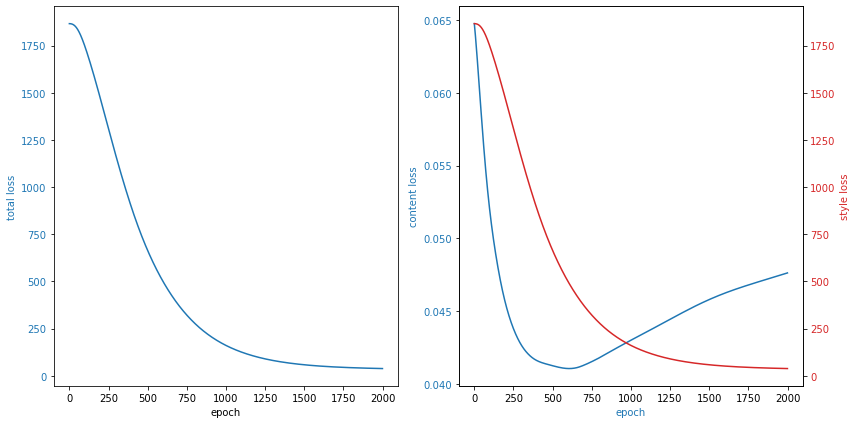

In [4]:
import utils
from utils import plot_curve
from importlib import reload
reload(utils)

utils.plot_curve(content_losses, style_losses, losses, same_y_scale=False)

# 